In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

# Ближайшие соседи

В этом разделе мы разработаем метод классификации по ближайшим соседям.

## Хроническая болезнь почек
Рассмотрим пример. Мы собираемся работать с набором данных, который был собран, чтобы помочь врачам диагностировать хроническую болезнь почек (ХБП). Каждая строка в наборе данных представляет одного пациента, диагноз которого известен. Для каждого пациента у нас есть результаты анализов крови. Мы хотим узнать, какие показатели наиболее полезны для диагностики ХБП, и разработать способ классификации будущих пациентов как "Есть ХБП" или "Нет ХБП" на основе результатов анализа крови.

In [2]:
ckd = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/ckd.csv') \
                 .rename({'Blood Glucose Random': 'Glucose'}, axis=1)
ckd.head()

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,...,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
0,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,1
1,53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,...,29,12100,3.7,yes,yes,no,poor,no,yes,1
2,63,70,1.010,3,0,abnormal,abnormal,present,notpresent,380,...,32,4500,3.8,yes,yes,no,poor,yes,no,1
3,68,80,1.010,3,2,normal,abnormal,present,present,157,...,16,11000,2.6,yes,yes,yes,poor,yes,no,1
4,61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,...,24,9200,3.2,yes,yes,yes,poor,yes,yes,1


Некоторые переменные относятся к категориям (например, "аномально"), другие являются количественными. Все количественные переменные имеют разные шкалы. Мы хотим выполнять сравнения и оценивать расстояния, как правило, на глаз, так что выберем всего несколько переменных и будем использовать стандартные единицы. Тогда нам не придется беспокоиться о шкале измерения каждой переменной.


In [3]:
def standard_units(xyz):
    "Convert any array of numbers to standard units."
    return (xyz - np.mean(xyz)) / np.std(xyz) 

ckd[['Hemoglobin',
     'Glucose',
     'White Blood Cell Count']] = ckd[['Hemoglobin', 
                                       'Glucose',
                                       'White Blood Cell Count']] \
                                  .apply(standard_units)
ckd = ckd[['Hemoglobin',
           'Glucose',
           'White Blood Cell Count',
           'Class']]
ckd

,Hemoglobin,Glucose,White Blood Cell Count,Class
0,-0.865744,-0.221549,-0.569768,1
1,-1.457446,-0.947597,1.162684,1
2,-1.004968,3.841231,-1.275582,1
3,-2.814879,0.396364,0.809777,1
4,-2.083954,0.643529,0.232293,1
...,...,...,...,...
153,0.700526,0.133751,-0.569768,0
154,0.978974,-0.870358,-0.216861,0
155,0.735332,-0.484162,-0.601850,0
156,0.178436,-0.267893,-0.409356,0


Рассмотрим два столбца: уровень гемоглобина и уровень глюкозы в крови пациента (в случайное время дня, не на голодный желудок).

Нарисуем точечную диаграмму для визуализации связи между двумя переменными. Синие точки — пациенты с ХБП; золотые — без ХБП. Какие результаты анализов указывают на ХБП?

In [4]:
ckd['Color'] = ckd['Class'].map({1: 'darkblue', 0: 'gold'})

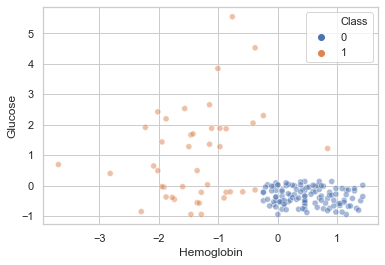

In [5]:
sns.scatterplot(data=ckd, x='Hemoglobin', y='Glucose', hue='Class', alpha=.5);

Предположим, Алиса — новый пациент, которого нет в наборе данных. Если знать уровень гемоглобина и глюкозы Алисы, можно ли спрогнозировать, есть ли у нее ХБП? Разумеется, можно! Вы видите четкую закономерность: точки в правом нижнем углу показывают людей, у которых нет ХБП, а у остальных есть эта болезнь. Человеку эта закономерность очевидна. Но как запрограммировать компьютер, чтобы он автоматически выявлял такие закономерности?

## Классификатор ближайших соседей
Существует множество типов закономерностей и алгоритмов классификации. Я расскажу об удивительно эффективном алгоритме. Он называется классификация по ближайшим соседям. Рассмотрим на примере. Если у нас есть показатели гемоглобина и глюкозы Алисы, мы можем разместить ее на графике: гемоглобин — это координата по оси x, а глюкоза — координата по оси y. Теперь, чтобы предсказать, есть ли у нее ХБП, можно найти ближайшую точку на диаграмме и посмотреть, синяя она или золотая. Мы предполагаем, что у Алисы тот же диагноз, что и у этого пациента.

Другими словами, чтобы классифицировать Алису по наличию ХБП, мы находим пациента в обучающем наборе, который находится ближе всего к Алисе, а затем основываем прогноз для Алисы на диагнозе этого пациента. Интуиция подсказывает, что, если две точки находятся рядом, у них схожие показатели, а значит, диагноз, скорее всего, будет одинаковым. Мы не знаем диагноз Алисы, но знаем диагноз всех пациентов в обучающем наборе, так что мы находим пациента, чьи показатели наиболее схожи с Алисиными, и на основе его диагноза предсказываем диагноз Алисы.

На приведенном ниже графика красная точка обозначает Алису. Она соединена черной линией с ближайшей к ней точкой, которая представляет ее ближайшего соседа в обучающем наборе. Рисунок создается с помощью функции `show_closest`. Она принимает массив, представляющий координаты $x$ и $y$ точки Алисы. Измените эти значения, чтобы увидеть, как меняется ближайшая точка. Обращайте особое внимание на цвет этой точки — синий или золотой.

In [6]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

In [7]:
# In this example, Alice's Hemoglobin attribute is 0 and her Glucose is 1.5.
alice = np.array([0, 1.5])
HemoGl = ckd.drop(['White Blood Cell Count', 'Color', 'Class'], axis=1)
HemoGl['Distance'] = HemoGl.apply(lambda x: distance(x, alice), axis=1)
HemoGl.sort_values(by='Distance', inplace=True)
x_closest, y_closest = HemoGl.iloc[0][['Hemoglobin', 'Glucose']]
HemoGl.iloc[0][['Hemoglobin', 'Glucose']]

Hemoglobin   -0.413266
Glucose       2.049282
Name: 6, dtype: float64

In [8]:
def show_closest(point):
    """point = array([x,y])
    gives the coordinates of a new point
    shown in red"""

    HemoGl = ckd.drop(['White Blood Cell Count', 'Color', 'Class'], axis=1)
    HemoGl['Distance'] = HemoGl.apply(lambda x: distance(x, point), axis=1)
    HemoGl.sort_values(by='Distance', inplace=True)
    x_closest, y_closest = HemoGl.iloc[0][['Hemoglobin', 'Glucose']]
    sns.scatterplot(data=ckd, x='Hemoglobin', y='Glucose', hue='Class', alpha=.5)
    plt.scatter(point[0], point[1], color='red', s=30, alpha=.5)
    plt.plot(np.array([point[0], x_closest]), np.array([point[1], y_closest]),
                                                                 color='b', lw=1.5);

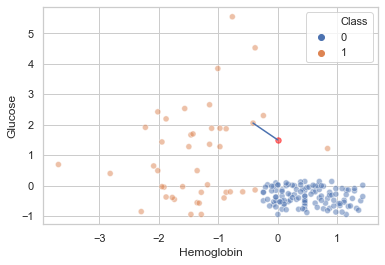

In [9]:
show_closest(alice)

Итак, наш классификатор по ближайшему соседу выглядит следующим образом:

- Найдите в обучающем наборе точку, ближайшую к новой точке.
- Если ближайшая точка входит в класс "Есть ХБП", отнесите новую точку к этому же классу.
- Если ближайшая точка входит в класс "Нет ХБП", отнесите новую точку к этому же классу.

Точечная диаграмма показывает, что классификатор по ближайшим соседям должен быть точным. Точки в правом нижем углу относятся к классу "Нет ХБП", так как их ближайший сосед — синяя точка. Остальные точки относятся к классу "Есть ХБП", так как их ближайший сосед — золотая точка. Так что стратегия ближайших соседей в этом примере сработала, как ожидалось.

## Граница принятия решений
Иногда полезно визуализировать классификатор в виде различных атрибутов, по которым классификатор определит класс "Есть ХБП", и атрибутам, которые указывают на класс "Нет ХБП". В итоге мы создадим некоторую границу между двумя классами. Точки по одну сторону границы будут классифицироваться как "Есть ХБП", а по другую — "Нет ХБП". Эта граница называется границей принятия решений. У каждого классификатора будет своя граница принятия решений. Граница принятия решений — это просто способ визуализации критериев, которые классификатор использует для классификации точек.

В первом примере точка Алисы имеет координаты (0, 1,5). Обратите внимание, что ближайший сосед является синим. Теперь попробуйте уменьшить высоту (координату $y$) точки. Вы увидите, что при $y=0,95$ ближайший сосед становится синим.

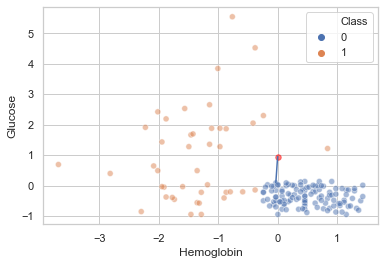

In [10]:
alice = np.array([0, 0.95])
show_closest(alice)

In [49]:
x_array = []
y_array = []
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array.append(x)
        y_array.append(y)

test_grid = pd.DataFrame(zip(x_array, y_array), columns=['Hemoglobin', 'Glucose'])

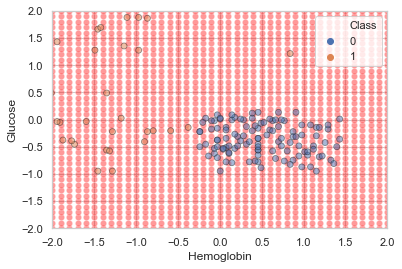

In [13]:
sns.scatterplot(data=test_grid, x='Hemoglobin', y='Glucose', color='red', alpha=0.4, s=40)
sns.scatterplot(data=ckd, x='Hemoglobin', y='Glucose', hue='Class',
                                                                 edgecolor='k', alpha=0.5)

plt.xlim(-2, 2)
plt.ylim(-2, 2);

Каждая из красных точек имеет ближайших соседей в обучающем наборе (те же синие и золотые точки, что и раньше). Для некоторых красных точек можно легко определить, является ли ближайший сосед синим или золотым. Для других это сложно определить на глаз. Это точки, близкие к границе принятия решений.

Но компьютер может легко определить ближайшего соседа каждой точки. Попробуем применить классификатор по ближайшему соседу к каждой красной точке:

Для каждой красной точки нужно найти ближайшую точку в обучающем наборе. Затем она изменит свой цвет на цвет ближайшего соседа.

На получившемся графике видно, какие точки попали в класс "Есть ХБП" (золотые), а какие — в класс "Нет ХБП" (синие).

In [12]:
def classify_grid(training, test, k):
    c = np.zeros(len(test))
    for i in range(len(test)):
        # Run the classifier on the i-th patient in the test set
        c[i] = classify(training, test.iloc[i], k)
    return c

In [56]:
c = classify_grid(ckd.drop(['White Blood Cell Count', 'Color'], axis=1), test_grid, 1)

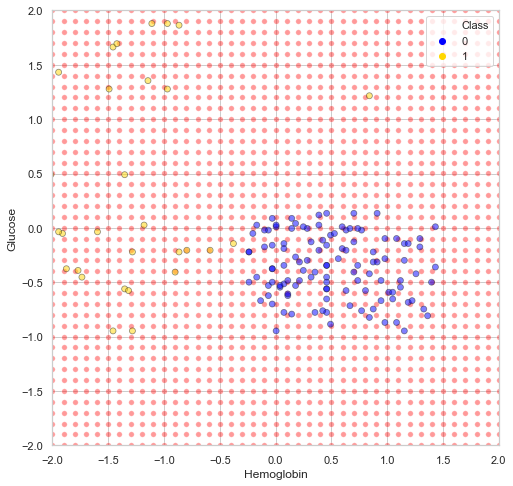

In [58]:
plt.figure(figsize=(8, 8))

sns.scatterplot(data=test_grid, x='Hemoglobin', y='Glucose', color='red',
                                                       alpha=0.4, s=30, legend=False)
sns.set_palette(sns.color_palette(['blue', 'gold']))
sns.scatterplot(data=ckd, x='Hemoglobin', y='Glucose', hue='Class',
                                                            edgecolor='k', alpha=0.5)

plt.xlim(-2, 2)
plt.ylim(-2, 2);

Граница принятия решений проходит там, где классификатор переходит от перекрашивания точек в синий к перекрашиванию точек в золотой.

## k ближайших соседей
Однако разделение между двумя классами не всегда бывает таким четким. Например, предположим, что вместо уровня гемоглобина мы будем считать количество лейкоцитов. Вот что произойдет:

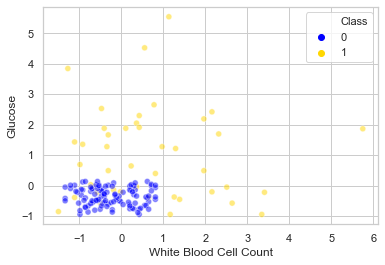

In [21]:
sns.scatterplot(data=ckd, x='White Blood Cell Count', y='Glucose', hue='Class', alpha=.5);

Как видите, пациенты без ХБП находятся в левом нижнем углу. Большинство пациентов с ХБП расположены над этой группой или справа от нее. Но не все. Некоторые пациенты с ХБП оказались в левом нижнем углу рисунка (вы видите несколько синих точек среди золотых). Это означает, что вы не можете диагностировать ХБП только по этим двум показателям крови.

Сможем ли мы спрогнозировать наличие у Алисы ХБП по уровню глюкозы и числу лейкоцитов? Да, можем, но этот прогноз не будет верным на 100%. Интуитивно кажется, что существует естественная стратегия прогнозирования — местоположение Алисы на точечной диаграмме. Если она находится в левом нижнем углу, у нее нет ХБП, в противном случае — есть.

Это не идеальный вариант — наши прогнозы иногда будут ошибочными. (Подумайте: с какими пациентами мы будем ошибаться?) На диаграмме видно, что иногда у людей с ХБП уровень глюкозы и число лейкоцитов такие же, как у людей без ХБП, так что любой классификатор неизбежно сделает ошибочный прогноз для таких пациентов.

Можно ли автоматизировать эту задачу на компьютере? Классификатор по ближайшему соседу отлично подойдет для ее выполнения. Подумайте: насколько точными будут его прогнозы по сравнению с нашими, которые мы делаем на глаз? Когда они будут отличаться?

Его прогнозы будут очень похожи на наши, но иногда будут отличаться. В частности, если по результатам анализов Алиса окажется рядом с одной из синих точек в левом нижнем углу, мы решим, что у нее нет ХБП, а классификатор по ближайшему соседу предскажет, что есть.

Существует простое обобщение для классификатора по ближайшему соседу, которое устранит эту аномалию. Он называется классификатор по k ближайшим соседям. Чтобы спрогнозировать диагноз Алисы, мы возьмем не одного, а трех ближайших соседей и сделаем прогноз на основе диагноза этих трех точек. В частности, в качестве прогноза для диагноза Алисы мы будем использовать значение большинства из этих трех точек. Конечно, в числе три нет ничего особенного. Мы можем использовать четыре, пять или больше. (Часто бывает удобно выбрать нечетное число, чтобы не получилась ничья.) Как правило, мы устанавливаем число $k$ и прогнозируем диагноз Алисы на основании $k$ пациентов в обучающем наборе, которые расположены ближе всего к Алисе. Интуитивно мы понимаем, что это $k$ пациентов, чьи результаты анализов крови наиболее похожи на Алисины, поэтому разумно использовать их для диагностики.

Теперь классификатор по $k$ ближайших соседей будет работать так же, как наша стратегия на глаз.

# Обучение и проверка

Насколько эффективен наш классификатор по методу ближайших соседей? Чтобы ответить на этот вопрос, нам нужно узнать, как часто наши классификации верны. Если у пациента хроническая болезнь почек, какова вероятность, что классификатор это заметит?

Если пациент находится в нашем обучающем наборе, мы можем сразу же это узнать. Мы уже знаем, в каком классе находится пациент. Поэтому мы можем просто сравнить наш прогноз и действительный класс пациента.

Но цель классификатора — делать прогнозы для новых пациентов не из обучающего набора. Мы не знаем, к какому классу относятся эти пациенты, но можно сделать прогноз на основе нашего классификатора. Как узнать, точен ли прогноз?

Можно подождать медицинских анализов, а затем проверить, соответствует ли наш прогноз их результатам. Но при таком подходе к моменту, когда мы будем уверены в точности нашего прогноза, он уже ничем не поможет пациенту.

Вместо этого мы будем использовать наш классификатор на некоторых пациентах, класс которых нам известен. Затем мы вычислим, как часто наш классификатор оказывался прав. Эта пропорция поможет оценить точность прогноза классификатора для новых пациентов. Это называется _проверка_.

## Чрезмерно оптимистичная проверка
Обучающий набор кажется хорошим вариантом для проверки классификатора, так как мы знаем класс каждого пациента в обучающем наборе.

Но нужно быть осторожными. Такой подход чреват последствиями. И сейчас мы узнаем, почему.

Предположим, мы используем классификатор по одному ближайшему соседу, чтобы спрогнозировать, имеет ли пациент хроническую болезнь почек, на основе концентрации глюкозы и лейкоцитов.

Ранее мы говорили о том, что некоторые классификации будут ошибочными, так как синие и золотые точки перекрываются в нижнем левом углу.

Но как насчет точек в обучающем наборе, то есть точек, уже указанных на точечной диаграмме? Они будут классифицироваться ошибочно?

Нет, не будут. Помните, что классификация по 1 ближайшему соседу учитывает точку в обучающем наборе, которая находится ближе всего к классифицируемой точке. Если классифицированная точка уже находится в обучающем наборе, то ее ближайшим соседом будет она сама! Поэтому она будет классифицирована по своему цвету, и это будет правильный прогноз, ведь каждая точка в обучающем наборе уже имеет правильный цвет.

Иными словами, **если мы используем наш обучающий набор для "проверки" классификатора по 1 ближайшему соседу, классификатор будет проходить проверку каждый раз.**

Задача выполнена. Какой чудесный классификатор!

Не совсем. Как мы уже заметили, новую точку в левом нижнем углу можно легко классифицировать неверно. В реальности 100 % точности не бывает.

Суть этого примера — показать, что не нужно использовать обучающий набор для проверки классификатора на его основе.

## Создание проверочного набора
В предыдущих главах мы видели, что для оценки доли отдельных пациентов в общей группе в соответствии с критерием можно использовать случайную выборку. К сожалению, мы видели, что обучающий набор не похож на случайную выборку совокупности всех пациентов в одном важном отношении. Наш классификатор делает правильные прогнозы для обучающего набора чаще, чем для населения в целом.

Когда мы вычислили уровни достоверности для числовых параметров, нам нужно было много новых случайных выборок из группы, но у нас был доступ только к одному примеру. Мы разрешили эту проблему, взяв повторные выборки из нашего примера.

Мы будем использовать аналогичный подход для проверки нашего классификатора. Мы создадим _две выборки из исходного обучающего набора, используем одну из них в качестве обучающего набора и другую — для проверки_.

Итак, у нас будет три группы:

 1. Обучающий набор, с которым можно выполнить любое количество исследований для создания классификатора.
 2. Отдельный проверочный набор, на котором можно опробовать наш классификатор и оценить долю правильных прогнозов.
 3. Группа пациентов, классы которых нам не известны.

Мы надеемся, что классификатор будет работать с этими пациентами так же эффективно, как в проверочном наборе.

Как создать обучающий и проверочный наборы? Разумеется, выбрать случайным образом.

В `ckd` 158 пациентов. Случайным образом разделим их пополам — для обучения и проверки. Для этого смешаем все строки, выберем первые 79 в качестве обучающего набора и оставшиеся 79 для проверки.

In [59]:
shuffled_ckd = ckd.sample(frac=1)
training = shuffled_ckd.take(np.arange(79))
testing = shuffled_ckd.take(np.arange(79, 158))

Теперь создадим классификатор на основе точек в обучающей выборке:

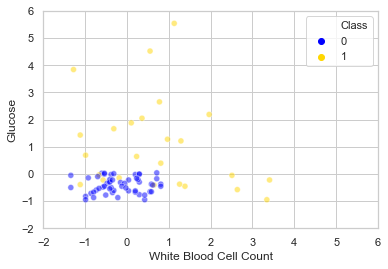

In [23]:
sns.scatterplot(data=training, x='White Blood Cell Count', y='Glucose',
                                                       hue='Class', alpha=.5)
plt.xlim(-2, 6)
plt.ylim(-2, 6);

Мы получим следующие области классификации и границы принятия решений:

In [60]:
x_array = []
y_array = []
for x in np.arange(-2, 6.1, 0.25):
    for y in np.arange(-2, 6.1, 0.25):
        x_array.append(x)
        y_array.append(y)

test_grid = pd.DataFrame(zip(x_array, y_array),
                                     columns=['White Blood Cell Count', 'Glucose'])

In [83]:
training

,Hemoglobin,Glucose,White Blood Cell Count,Class,Color
3,-2.814879,0.396364,0.809777,1,darkblue
135,0.491690,-0.885806,0.392705,0,gold
99,-0.065206,-0.020727,-0.569768,0,gold
66,0.700526,-0.128862,-0.698098,0,gold
8,-1.109386,1.879356,-0.409356,1,darkblue
...,...,...,...,...,...
93,0.074018,-0.345132,0.360623,0,gold
24,-0.378460,-0.144310,-0.184779,1,darkblue
111,1.431451,-0.360580,-0.409356,0,gold
62,0.213242,-0.314236,-0.409356,0,gold


In [84]:
training.drop(['Hemoglobin', 'Class', 'Color'], axis=1)

,Glucose,White Blood Cell Count
3,0.396364,0.809777
135,-0.885806,0.392705
99,-0.020727,-0.569768
66,-0.128862,-0.698098
8,1.879356,-0.409356
...,...,...
93,-0.345132,0.360623
24,-0.144310,-0.184779
111,-0.360580,-0.409356
62,-0.314236,-0.409356


In [87]:
c = classify_grid(training.drop(['Hemoglobin', 'Color'], axis=1), test_grid, 1)

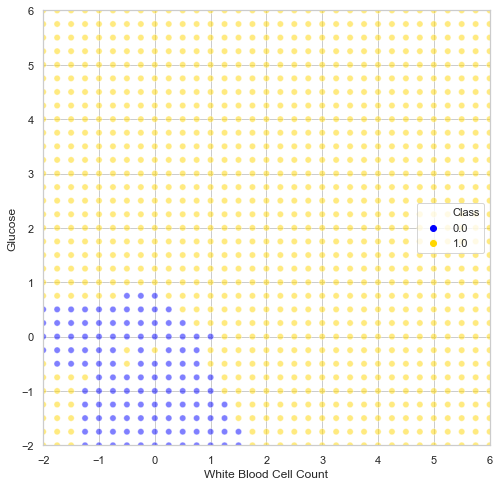

In [90]:
test_grid['Class'] = c
plt.figure(figsize=(8, 8))
sns.scatterplot(data=test_grid, x='White Blood Cell Count', y='Glucose',
                                                            hue='Class', alpha=0.5, s=40)

plt.xlim(-2, 6)
plt.ylim(-2, 6);

Поместите _проверочные_ данные на эту диаграмму, и вы увидите, что классификатор угадал почти все точки, но допустил и несколько ошибок. Например, некоторые синие точки проверочного набора классификатор определил как золотые.

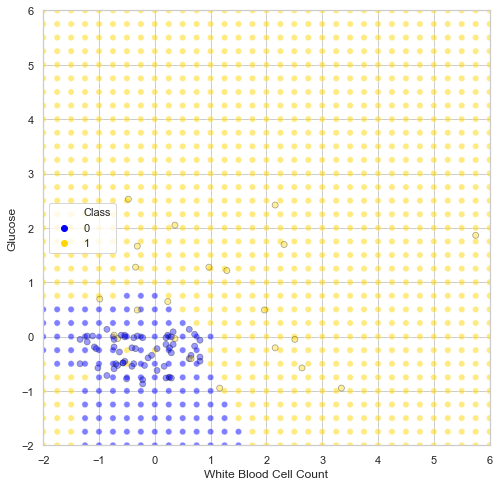

In [91]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=test_grid, x='White Blood Cell Count', y='Glucose',
                                                hue='Class', alpha=0.5, s=40, legend=False)
sns.scatterplot(data=testing, x='White Blood Cell Count', y='Glucose',
                                                    hue='Class', alpha=0.4, edgecolor='k')

plt.xlim(-2, 6)
plt.ylim(-2, 6);

Несмотря на некоторые ошибки, похоже, что классификатор довольно хорошо работает с проверочным набором. Если исходная выборка была выделена из группы случайным образом, мы надеемся, что классификатор будет работать с той же точностью и для всех остальных.

## Расстояние между точками при наличии двух атрибутов
Основное вычисление — определить расстояние между точкой Алисы и другими точками. Для этого в первую очередь нам нужен способ вычислить расстояние между любой парой точек.

Как это сделать? В двумерном пространстве это довольно просто. Если у нас есть две точки в координатах $(x_{0}, y_{0})$ и $(x_{1}, y_{1})$, расстояние между ними составит:

$$D = \sqrt{(x_{0} - x_{1})^2 + (y_{0} - y_{1})^2}$$

(Откуда взялась эта формула? Она основана на теореме Пифагора: у нас есть прямоугольный треугольник с катетами длиной $x_{0} - x_{1}$ и $y_{0} - y_{1}$, и мы хотим узнать длину гипотенузы.)

В следующем разделе мы увидим, что эту формулу можно дополнять при наличии более двух атрибутов. Сейчас используем формулу и операции с массивами, чтобы найти расстояние между Алисой и пациентом в строке 3.

In [92]:
ckd_attributes = ckd.filter(['Hemoglobin', 'Glucose'])

In [93]:
patient3 = ckd_attributes.iloc[3].values
alice, patient3

(array([0.  , 0.95]), array([-2.81487943,  0.39636401]))

In [94]:
distance = np.sqrt(np.sum((alice - patient3) ** 2))
distance

2.868807944668629

Нам требуется расстояние между Алисой и набором точек, так что напишем функцию с именем `distance`, которая вычислит расстояние между любой парой точек. Функция будет принимать два массива, каждый из которых содержит координаты $(x,y)$ точки. (Помните, что это уровень гемоглобина и глюкозы пациента.)

In [96]:
def distance(point1, point2):
    """Returns the Euclidean distance between point1 and point2.

    Each argument is an array containing the coordinates of a point."""
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [97]:
distance(alice, patient3)

2.868807944668629

Мы начали создавать классификатор: функция `distance` является первым стандартным блоком. Теперь перейдем к следующей части.

## Использование apply для всей строки
Если вы хотите применить функцию к каждому элементу столбца таблицы, это можно сделать с помощью вызова `table_name.apply(function_name)`. При этом вычисляется массив, состоящий из значений функции, если делать вызов для каждого элемента столбца. Поэтому каждая запись массива основана на соответствующей строке таблицы.

При использовании apply без указания метки столбца вся строка передается в функцию. Посмотрим, как это работает на очень маленькой таблице `t`, содержащей сведения о первых пяти пациентах из обучающего набора.

In [98]:
t = ckd_attributes.take(np.arange(5))
t

,Hemoglobin,Glucose
0,-0.865744,-0.221549
1,-1.457446,-0.947597
2,-1.004968,3.841231
3,-2.814879,0.396364
4,-2.083954,0.643529


В качестве примера предположим, что для каждого пациента необходимо выяснить, насколько необычны их самые необычные атрибуты. В частности, если уровень гемоглобина пациентки больше отличается от среднего, чем уровень глюкозы, мы хотим выяснить, насколько сильно он отличается от среднего. Если ее уровень глюкозы больше отличается от среднего, чем уровень гемоглобина, мы хотим подробнее изучить его отличие от среднего.

Для этого нужно вычислить максимум из абсолютного значения двух количеств. Можно преобразовать конкретную строку в массив и использовать операции с массивами.

In [99]:
def max_abs(row):
    return np.max(np.abs(np.array(row)))

Теперь можно применить `max_abs` к каждой строке таблицы `t`:

In [100]:
t['Glucose'].apply(max_abs)

0    0.221549
1    0.947597
2    3.841231
3    0.396364
4    0.643529
Name: Glucose, dtype: float64

Такой способ использования `apply` поможет нам создать следующий стандартный блок классификатора.

## $k$ ближайших соседей Алисы
Если мы хотим классифицировать Алису с помощью классификатора $k$ ближайших соседей, нам нужно определить $k$ ближайших соседей. Как это сделать? Предположим, $k = 5$. Тогда мы сделаем следующее:
- Шаг 1. Найдите расстояние между Алисой и каждой точкой в обучающем наборе.
- Шаг 2. Отсортируйте таблицу данных в порядке возрастания расстояний.
- Шаг 3. Возьмите первые пять строк отсортированной таблицы.

Шаги 2 и 3 кажутся простыми, при условии что нам известны расстояния. Сосредоточимся на шаге 1.

Вот Алиса:

In [101]:
alice = np.array([1, 1.1])

Нам нужна функция, которая находит расстояние между Алисой и другой точкой, чьи координаты содержатся в строке. Функция `distance` возвращает расстояние между любыми двумя точками, координаты которых находятся в массивах. Его можно использовать для определения `distance_from_alice`, который принимает строку в качестве аргумента и возвращает расстояние между этой строкой и Алисой.

In [102]:
def distance_from_alice(row):
    """Returns distance between Alice and a row of the attributes table"""
    return distance(alice, np.array(row))

In [103]:
distance_from_alice(ckd_attributes.iloc[3])

3.8792278462762924

Теперь можно выполнить операцию `apply` для функции `distance_from_alice` в каждой строке `ckd_attributes` и дополнить таблицу `ckd` расстояниями. Шаг 1 завершен.

In [104]:
distances = ckd_attributes.apply(distance_from_alice, axis=1)
ckd_with_distances = ckd.copy()
ckd_with_distances['Distance from Alice'] = distances
ckd_with_distances

,Hemoglobin,Glucose,White Blood Cell Count,Class,Color,Distance from Alice
0,-0.865744,-0.221549,-0.569768,1,darkblue,2.286371
1,-1.457446,-0.947597,1.162684,1,darkblue,3.198702
2,-1.004968,3.841231,-1.275582,1,darkblue,3.396210
3,-2.814879,0.396364,0.809777,1,darkblue,3.879228
4,-2.083954,0.643529,0.232293,1,darkblue,3.117553
...,...,...,...,...,...,...
153,0.700526,0.133751,-0.569768,0,gold,1.011594
154,0.978974,-0.870358,-0.216861,0,gold,1.970470
155,0.735332,-0.484162,-0.601850,0,gold,1.606120
156,0.178436,-0.267893,-0.409356,0,gold,1.595650


Для шага 2 отсортируем таблицу по возрастанию расстояния:

In [105]:
sorted_by_distance = ckd_with_distances.sort_values(by='Distance from Alice')
sorted_by_distance

,Hemoglobin,Glucose,White Blood Cell Count,Class,Color,Distance from Alice
14,0.839750,1.215099,1.291014,1,darkblue,0.197302
68,0.909362,0.133751,-0.858510,0,gold,0.970491
153,0.700526,0.133751,-0.569768,0,gold,1.011594
43,0.456884,0.133751,0.617283,0,gold,1.108428
157,0.735332,-0.005280,-0.537686,0,gold,1.136526
...,...,...,...,...,...,...
41,-0.378460,4.520935,0.553118,1,darkblue,3.688218
12,-2.292790,-0.854910,-1.500159,1,darkblue,3.829378
3,-2.814879,0.396364,0.809777,1,darkblue,3.879228
42,-3.685029,0.689873,-0.986840,1,darkblue,4.702946


Шаг 3. Первые 5 строк соответствуют пяти ближайшим соседям Алисы. Можно заменить 5 любым другим положительным целым числом.

In [106]:
alice_5_nearest_neighbors = sorted_by_distance.take(np.arange(5))
alice_5_nearest_neighbors

,Hemoglobin,Glucose,White Blood Cell Count,Class,Color,Distance from Alice
14,0.839750,1.215099,1.291014,1,darkblue,0.197302
68,0.909362,0.133751,-0.858510,0,gold,0.970491
153,0.700526,0.133751,-0.569768,0,gold,1.011594
43,0.456884,0.133751,0.617283,0,gold,1.108428
157,0.735332,-0.005280,-0.537686,0,gold,1.136526


Четыре из пяти ближайших соседей Алисы — это синие точки, а одна — золотая. Классификатор по 5 ближайшим соседям отнесет Алису к синим точкам и предскажет, что у нее есть хроническая болезнь почек.

In [107]:
sorted_by_distance['Distance from Alice'].iloc[0]

0.19730180446191034

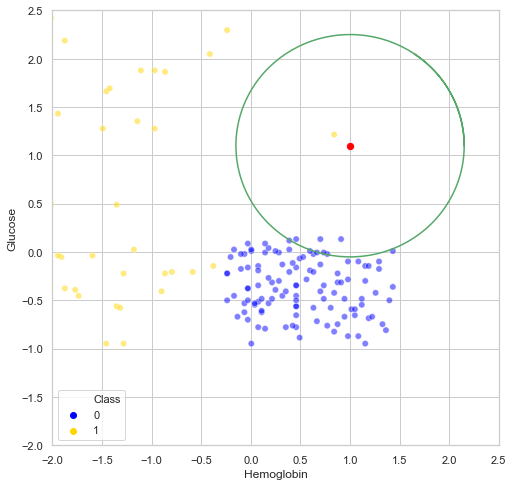

In [108]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=ckd, x='Hemoglobin', y='Glucose', hue='Class', s=40, alpha=.5)
#ckd.scatter('Hemoglobin', 'Glucose', group='Color')
plt.scatter(alice[0], alice[1], color='red', s=40)
radius = sorted_by_distance['Distance from Alice'].iloc[4] + 0.014
theta = np.arange(0, 2 * np.pi + 1, 2 * np.pi / 200)
plt.plot(radius * np.cos(theta ) + alice[0], radius * np.sin(theta) + alice[1],
                                                                 color='g', lw=1.5)
plt.xlim(-2, 2.5)
plt.ylim(-2, 2.5);

Мы на правильном пути реализации классификатора по $k$ ближайших соседей. В следующих двух разделах мы соберем все вместе и оценим точность.

# Реализация классификатора
Теперь все готово для реализации классификатора по методу $k$ ближайших соседей на основе нескольких атрибутов. Мы использовали только два атрибута для простоты визуализации. Но обычно прогнозы будут основываться на множестве атрибутов. Ниже приведен пример, демонстрирующий, как несколько атрибутов могут быть лучше, чем два.

## Проверка подлинности банкнот
На этот раз мы рассмотрим, как спрогнозировать подлинность банкноты (например, $20). Исследователи составили набор данных на основе фотографий множества отдельных банкнот — фальшивых и подлинных. Они рассчитали несколько чисел на основе каждого изображения, используя методы, в подробности которых мы не будем вдаваться. Итак, для каждой банкноты нам известно несколько чисел, рассчитанных по фотографии, а также ее класс (фальшивая или нет). Загрузим данные в таблицу и посмотрим.

In [109]:
banknotes = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/banknote.csv')
banknotes.head()

,WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Мы увидим, можно ли по первым двум числам определить подлинность. Вот точечная диаграмма:

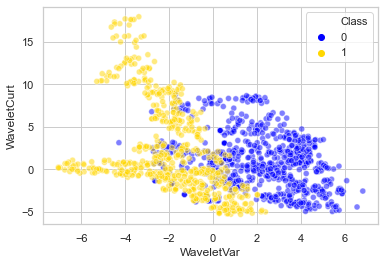

In [110]:
sns.scatterplot(data=banknotes, x='WaveletVar', y='WaveletCurt', hue='Class', alpha=.5);

Интересно. Эти два измерения, кажется, помогают определить, является ли банкнота фальшивой. Однако в этом примере видно, что синий и золотой кластеры частично перекрываются. Это означает, что существуют некоторые изображения, по которым трудно определить подлинность банкноты на основе только этих двух чисел. Вы по-прежнему можете использовать классификатор по методу k ближайших соседей для прогнозирования подлинности банкноты.

Подумайте. Предположим, мы использовали $k=11$. На каких частях графика классификатор сделает правильный прогноз, а где ошибется? Как будет выглядеть граница принятия решений?

Закономерности, найденные в данных, могут быть странными. Например, вот что мы получаем, используя другую пару измерений с изображений.

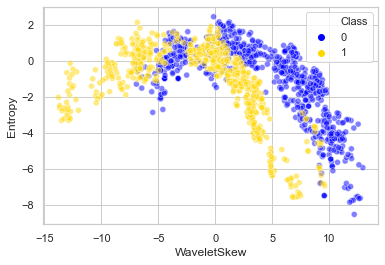

In [111]:
sns.scatterplot(data=banknotes, x='WaveletSkew', y='Entropy', hue='Class', alpha=.5);

Похоже, это закономерность, но очень сложная. Тем не менее классификатор по методу $k$ ближайших соседей по-прежнему можно использовать для выявления закономерностей. В этом примере показано, каким эффективным может быть машинное обучение: оно может использовать даже закономерности, которые мы не ожидали или не подумали бы запрограммировать.

## Несколько атрибутов
До сих пор мы предполагали, что у нас ровно два атрибута, которые можно использовать для прогнозирования. Что, если бы их было больше двух? Например, что, если их три?

Вот что интересно: в этом случае можно использовать те же принципы. Достаточно создать трехмерную точечную диаграмму вместо двухмерной. Вы по-прежнему можете использовать классификатор по методу k ближайших соседей, но теперь вычислять расстояния в трех измерениях, а не двух. Это очень просто. Здорово!

На самом деле, в числе два или три нет ничего особенного. Если у вас четыре атрибута, можно использовать классификатор по методу k ближайших соседей в четырех измерениях. Пять атрибутов? Пять измерений. И это еще не предел! Все это работает для любого числа атрибутов. Просто используется больше измерений. Визуализировать это невозможно, но это нормально. Алгоритм компьютера прекрасно все обобщает. Вам лишь нужна возможность вычислить расстояние, а это не сложно. Просто поразительно!

Например, посмотрим, что происходит при попытке предсказать, является ли банкнота фальшивой, используя три измерения вместо двух. Вот что вы получаете:

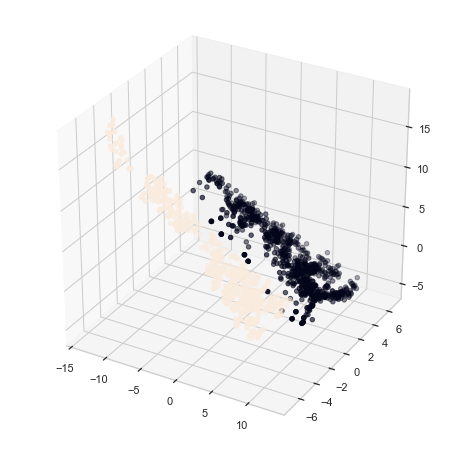

In [112]:
ax = plt.figure(figsize=(8, 8)).add_subplot(111, projection='3d')
ax.scatter(banknotes['WaveletSkew'],
           banknotes['WaveletVar'],
           banknotes['WaveletCurt'],
           c=banknotes['Class']);

Замечательно! При наличии только двух атрибутов кластеры отчасти перекрывались (то есть классификатор мог делать ошибки, если указатели находились в области перекрытия). Но при использовании трех атрибутов два кластера почти не перекрываются. Иными словами, классификатор, использующий три атрибута, будет более точным, чем классификатор с двумя.

Это обычное явление в классификации. Каждый атрибут потенциально может дать новые сведения, поэтому чем больше атрибутов, тем лучше может быть классификатор. Минус в том, что теперь нам нужно собрать больше информации для измерения значения каждого атрибута, но этот недостаток компенсируется, если точность классификатора значительно возрастает.

Итак, вы уже знаете, как использовать классификацию по k ближайших соседей для прогнозирования ответа на вопрос "да/нет" на основе значений некоторых атрибутов, если у вас есть обучающий набор с примерами, где известен правильный прогноз. Общая стратегия

 1. Определите некоторые атрибуты, которые, по вашему мнению, могут помочь вам спрогнозировать ответ на вопрос.
 2. Соберите обучающий набор примеров, где вы знаете значения атрибутов, а также правильный прогноз.
 3. Чтобы делать прогнозы в будущем, измерьте значения атрибутов, а затем используйте классификацию по методу $k$ ближайших соседей для прогнозирования ответа на вопрос.
 
Мы знаем, как вычислить расстояние в двухмерном пространстве. Если у нас есть две точки в координатах $(x_{0}, y_{0})$ b $(x_{1}, y_{1})$, расстояние между ними составит

$$D = \sqrt{(x_{0} - x_{1})^2 + (y_{0} - y_{1})^2}$$

В трехмерном пространстве точки имеют координаты $(x_{0}, y_{0}, z_{0})$ и $(x_{1}, y_{1}, z_{1})$, а формула для расчета расстояния между ними выглядит следующим образом:

$$D = \sqrt{(x_{0} - x_{1})^2 + (y_{0} - y_{1})^2 + (z_{0} - z_{1})^2}$$

$n$-мерное пространство довольно сложно представить, но, я думаю, вы поняли, как строится формула: мы суммируем квадраты разницы между координатами по каждой оси, а затем вычисляем квадратный корень.

В последнем разделе мы определили функцию `distance`, которая возвращала расстояние между двумя точками. Мы использовали ее в двух измерениях, но, к счастью, функции не важно, сколько у нас измерений! Она просто вычитает два массива координат (любой длины), возводит разность в квадрат, все складывает и вычисляет квадратный корень. Для работы с несколькими измерениями не нужно изменять код.

In [113]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2) ** 2))

Воспользуемся этим в новом наборе данных. Таблица `wine` содержит химический состав 178 различных итальянских вин. Классы — это сорта винограда, или культивары. Существует три класса, но посмотрим, можно ли отличить класс 1 от двух других.

In [114]:
wine = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/wine.csv')
wine.head(10)

,Class,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diulted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
6,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
7,1,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
8,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
9,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


Первые два вида вина находятся в классе 1. Чтобы найти расстояние между ними, сначала необходимо получить таблицу только атрибутов.

In [115]:
def is_one(x):
    if x == 1:
        return 1
    else:
        return 0

wine['Class'] = wine['Class'].apply(is_one)

In [116]:
wine_attributes = wine.drop(['Class'], axis=1)

In [117]:
distance(wine_attributes.iloc[0], wine_attributes.iloc[1])

31.265012394048398

Последнее вино в таблице принадлежит к классу 0. Расстояние от первого вина:

In [118]:
distance(wine_attributes.iloc[0], wine_attributes.iloc[-1])

506.05936766351834

Это гораздо больше! Создадим визуализацию, чтобы увидеть, действительно ли класс 1 выглядит иначе, чем класс 0.

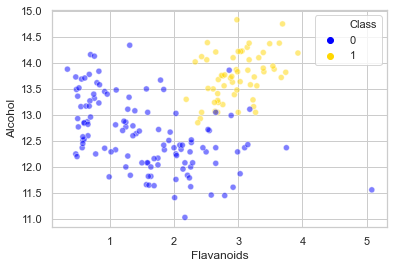

In [119]:
sns.scatterplot(data=wine, x='Flavanoids', y='Alcohol', hue='Class', alpha=.5);

Синие точки (класс 1) почти полностью отделены от золотых. Мы видим, почему расстояние между двумя винами класса 1 будет меньше расстояния между винами двух разных классов. Аналогичное явление также можно увидеть с другой парой атрибутов:

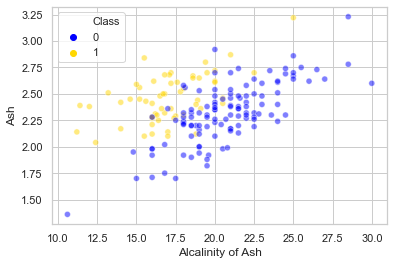

In [120]:
sns.scatterplot(data=wine, x='Alcalinity of Ash', y='Ash', hue='Class', alpha=.5);

Но для некоторых пар все не так очевидно.

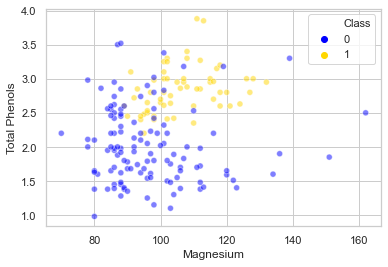

In [121]:
sns.scatterplot(data=wine, x='Magnesium', y='Total Phenols', hue='Class', alpha=.5);

Посмотрим, можно ли реализовать классификатор на основе всех атрибутов. После этого мы посмотрим, насколько он точен.

## План реализации
Пора написать код для реализации классификатора. Входные данные — это `point`, которые нужно классифицировать. Классификатор ищет $k$ ближайших соседей для point из обучающего набора. Итак, наш подход будет выглядеть следующим образом.

 1. Найти ближайшие $k$ соседей для point, т. е. $k$ вин из обучающего набора, которые наиболее похожи на point.

 2. Посмотреть на классы этих $k$ соседей и найти наиболее распространенный класс вин на основе большинства. Использовать это в качестве прогнозируемого класса для `point`.

Это ляжет в основу структуры нашего кода Python.

```python
def closest(training, p, k):
    ...

def majority(topkclasses):
    ...

def classify(training, p, k):
    kclosest = closest(training, p, k)
    kclosest.classes = kclosest['Class']
    return majority(kclosest)
```

### Шаг реализации 1
Чтобы выполнить первый шаг для данных о хронической болезни почек, нам пришлось вычислить расстояние от каждого пациента в обучающем наборе до point, сортировать их по расстоянию и взять $k$ ближайших пациентов в обучающем наборе.

Мы сделали это в предыдущем разделе с точкой, соответствующей Алисе. Обобщим этот код.

In [14]:
def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class', axis=1)
    def distance_from_point(row):
        return distance(new_point, row)
    return attributes.apply(distance_from_point, axis=1)

def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    training['Distance'] = all_distances(training, new_point)
    return training

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort_values(by='Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

Посмотрим, как это работает с нашими данными `wine`. Мы просто возьмем первое вино и найдем пять ближайших соседей среди всех вин. Помните, что, поскольку это вино входит в набор данных, оно является своим ближайшим соседом. Поэтому мы должны увидеть его в верхней части списка. За ним буду следовать четыре других вина.

Сначала извлечем его атрибуты:

In [123]:
special_wine = wine.drop(['Class'], axis=1).loc[0]

Теперь найдем пять ближайших соседей.

In [124]:
closest(wine, special_wine, 5)

,Class,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diulted wines,Proline,Distance
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0.000000
54,1,13.74,1.67,2.25,16.4,118,2.60,2.90,0.21,1.62,5.85,0.92,3.20,1060,10.392805
45,1,14.21,4.04,2.44,18.9,111,2.85,2.65,0.30,1.25,5.24,0.87,3.33,1080,22.340748
48,1,14.10,2.02,2.40,18.8,103,2.75,2.92,0.32,2.38,6.20,1.07,2.75,1060,24.760232
46,1,14.38,3.59,2.28,16.0,102,3.25,3.17,0.27,2.19,4.90,1.04,3.44,1065,25.094663


Есть! Первая строка является ближайшим соседом, то есть самой точкой — в столбце `Distance` указано значение 0, как ожидалось. Все пять ближайших соседей имеют класс 1, и это согласуется с предыдущим наблюдением о том, что класс вин 1 сгруппирован в некоторых измерениях.

### Шаги реализации 2 и 3
Далее нужно взять большинство из ближайших соседей и назначить нашей точке тот же класс, что и у большинства.

In [15]:
def majority(topkclasses):
    ones = (topkclasses == 1).sum()
    zeros = (topkclasses == 0).sum()
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk['Class']
    return majority(topkclasses)

In [125]:
classify(wine, special_wine, 5)

1

Если изменить `special_wine,` чтобы он был последним в наборе данных, сможет ли наш классификатор определить, что он находится в классе 0?

In [126]:
special_wine = wine.drop(['Class'], axis=1).iloc[-1]
classify(wine, special_wine, 5)

0

Да! Классификатор определяет класс правильно.

Но мы еще не знаем, определяет ли он другие вина, и понимаем, что тестирование на винах, которые уже входят в обучающий набор, может быть слишком оптимистичным. В последнем разделе этой главы мы будем разделять вина на обучающий и проверочный наборы, а затем измерять точность классификатора в тестовом наборе.

# Точность классификатора

Чтобы узнать, насколько хорошо работает классификатор, мы можем поместить 50% данных в обучающий набор, а другие 50% — в проверочный. В сущности, мы откладываем некоторые данные для последующего использования, чтобы измерить точность нашего классификатора. Мы называем это *проверочным набором*. Иногда данные для проверки называют *контрольной выборкой*, а стратегию для оценки точности — *контрольным методом*.

Обратите внимание, что этот подход требует дисциплины. Прежде чем приступить к применению методов машинного обучения, необходимо взять некоторые данные и отложить их для проверки. Не используйте проверочный набор для разработки классификатора — обучения, настройки параметров или обдумывания вариантов улучшения классификатора. Используйте его только один раз в самом конце, после завершения работы над классификатором, когда потребуется беспристрастная оценка его точности.

## Измерение точности классификатора вин
Итак, попробуем применить контрольный метод, чтобы оценить эффективность классификатора по методу $k$ ближайших соседей для различения вин. В наборе данных имеется 178 вин, поэтому мы случайным образом разделим его пополам и поместим 89 вин в обучающий набор и 89 — в проверочный.


In [127]:
shuffled_wine = wine.sample(frac=1)
training_set = shuffled_wine.take(np.arange(89))
test_set  = shuffled_wine.take(np.arange(89, 178))

Мы обучим классификатор на 89 винах в обучающем наборе, а затем оценим его точность на проверочном наборе. Чтобы упростить задачу, мы напишем функцию для оценки классификатора на каждом вине в проверочном наборе:

In [128]:
def count_zero(array):
    """Counts the number of 0's in an array"""
    return len(array) - np.count_nonzero(array)

def count_equal(array1, array2):
    """Takes two numerical arrays of equal length
    and counts the indices where the two are equal"""
    return count_zero(array1 - array2)

def evaluate_accuracy(training, test, k):
    test_attributes = test.drop(['Class'], axis=1)
    def classify_testrow(row):
        return classify(training, row, k)
    c = test_attributes.apply(classify_testrow, axis=1)
    return count_equal(c, test['Class']) / len(test)

Теперь посмотрим, что у нас получилось. Мы выберем число произвольно: $k=5$.

In [129]:
evaluate_accuracy(training_set, test_set, 5)

0.8426966292134831

Для простого классификатора неплохая точность.

## Диагностика рака молочной железы
Теперь рассмотрим пример диагностики рака молочной железы. Меня вдохновила Бриттани Венгер (Brittany Wenger), которая победила на национальной научной выставке Google в 2012 году будучи 17-летней школьницей.

Проект Бриттани был направлен на создание алгоритма классификации для диагностики рака молочной железы. Она выиграл главный приз за создание алгоритма, точность которого была почти 99%.

Посмотрим, что можно сделать на основе принципов, с которыми мы познакомились в этом курсе.

Я подробнее расскажу о наборе данных. По сути, если у женщины есть уплотнение в груди, врач может взять биопсию, чтобы проверить, злокачественное ли оно. Для этого существует несколько процедур. Бриттани выбрала аспирацию иглой, так как это наименее инвазивный метод. Врач получает образец ткани, помещает его под микроскоп, фотографирует, а затем специалист анализирует изображение, чтобы определить злокачественное образование.

К сожалению, различия между доброкачественными и злокачественными образованиями не всегда очевидны. Исследователи изучают возможность применения машинного обучения для этой задачи. Идея состоит в том, что специалист в лаборатории будет анализировать изображение и вычислять различные атрибуты, например: размер клетки, количество вариаций в размерах клеток и т. д. Затем мы попытаемся использовать эти сведения для прогнозирования (классификации) того, является ли образец злокачественным. У нас есть обучающий набор прошлых примеров женщин, диагноз которых мы знаем, и мы надеемся, что наш алгоритм машинного обучения может использовать их, чтобы научиться прогнозировать диагноз будущих пациенток.

В итоге мы получаем следующий набор данных. В столбце `Class` значение 1 означает злокачественное образование (рак); а 0 — доброкачественное (не рак).

In [130]:
patients = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/breast-cancer.csv').drop('ID', axis=1)
patients.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


Итак, у нас есть 9 различных атрибутов. Я не знаю, как нарисовать 9-мерную точечную диаграмму, так что я возьму только два атрибута:

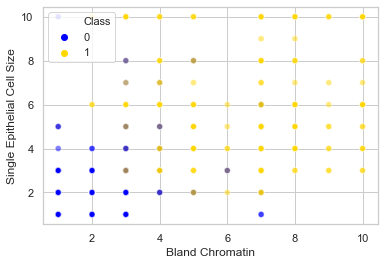

In [131]:
sns.scatterplot(data=patients, x='Bland Chromatin', y='Single Epithelial Cell Size', 
                                                               hue='Class', alpha=.5);

Ой. Этот график вводит нас в заблуждение, так как существует множество точек, имеющих одинаковые значения для координат $x$ и $y$. Чтобы упростить просмотр всех точек данных, я добавлю немного случайных колебаний к значениям $x$ и $y$. Вот что получилось:

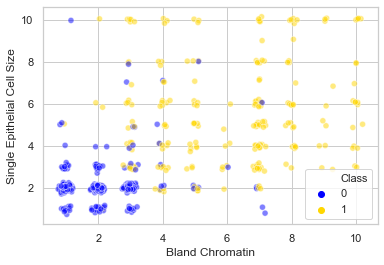

In [132]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

patients_randomize = patients[['Bland Chromatin', 'Single Epithelial Cell Size', 'Class']]
patients_randomize['Bland Chromatin'] = \
                                    randomize_column(patients_randomize['Bland Chromatin'])
patients_randomize['Single Epithelial Cell Size'] = \
                        randomize_column(patients_randomize['Single Epithelial Cell Size'])
sns.scatterplot(data=patients_randomize, x='Bland Chromatin',
                      y='Single Epithelial Cell Size', hue='Class', alpha=.5);

Например, здесь множество образцов, где хроматин = 2 и размер эпителиальных клеток = 2, все они не злокачественные.

Помните, что отклонения здесь только для удобства просмотра, чтобы мы получили представление о данных. Теперь мы готовы работать с данными и используем исходные данные (без отклонений).

Сначала мы создадим обучающий и проверочный наборы. В наборе данных имеется 683 пациента, поэтому мы случайным образом разделим его пополам и поместим 342 пациента в обучающий набор и 341 — в проверочный.

In [133]:
shuffled_patients = patients.sample(683)
training_set = shuffled_patients.take(np.arange(342))
test_set  = shuffled_patients.take(np.arange(342, 683))

Снова используем пять ближайших соседей и посмотрим, насколько хорошо работает классификатор.

In [379]:
evaluate_accuracy(training_set, test_set, 5)

0.9765395894428153

Точность более 97%. Неплохо! Довольно хороший результат для такой простой методики.

Кстати, у Бриттани Венгер получилось еще лучше. Какой метод она использовала? Отличие ее подхода в применении оценки достоверности — ее алгоритм умел определять, когда точный прогноз был невозможен, для этих пациентов он даже не пытался угадать диагноз. Ее алгоритм был точен для 99% пациентов, для которых он делал прогноз, так что это добавление оказалось полезным.